# Setup

Here I will go over setting up our interfaces and emulators from a raw spectral library to prepare us for fitting some data in further examples.

### Getting the Grid

To begin, we need a spectral model library that we will use for our fitting. One common example are the PHOENIX models, most recently computed by T.O. Husser. We provide many interfaces directly with different libraries, which can be viewed in [Raw Grid Interfaces](../api/grid_tools.rst#raw-grid-interfaces).

As a convenience, we provide a helper to download Sonoora Bobcat models from the Zenodo servers. Note this will skip any files already on disk.

In [1]:
import numpy as np

from Starfish.grid_tools import download_sonora_bobcat_models
download_sonora_bobcat_models("sonora_bobcat", grids = ["spectra_m+0.0"])

Now that we have the files downloaded, let's set up a grid interface

In [2]:
from Starfish.grid_tools import SonoraGridInterface

grid = SonoraGridInterface(path="sonora_bobcat/spectra_m+0.0", air = False)

From here, we will want to set up our HDF5 interface that will allow us to go on to using the spectral emulator, but first we need to determine our model subset and instrument.

### Setting up the HDF5 Interface

We set up an HDF5 interface in order to allow much quicker reading and writing than compared to loading FITS files over and over again. In addition, when considering the application to our likelihood methods, we know that for a given dataset, any effects characteristic of the instrument can be pre-applied to our models, saving on computation time during the maximum likelihood estimation.

Looking towards our fitting examples, we know we will try fitting some data from MIRI MRS 1A. This instrument is available in our grid tools, but if yours isn't, you can always supply the FWHM in km/s. The FWHM ($\Gamma$) can be found using the resolving power, $R$

$$ \Gamma = \frac{c}{R} $$

with $c$ in km/s. Let’s also say that, for a given dataset, we want to only use a reasonable subset of our original model grid. The data provided in future examples is a ~F3V star, so we will limit our model parameter ranges appropriately.

In [3]:
from Starfish.grid_tools.instruments import *
from Starfish.grid_tools import HDF5Creator
import numpy as np

creator = HDF5Creator(
    grid, "SONORA_grid_MIRI_MRS_1A.hdf5", instrument=MIRI_MRS_1A()
)
creator.process_grid()

Processing [2400.     5.5]: 100%|██████████| 429/429 [05:21<00:00,  1.33it/s]  


### Setting up the Spectral Emulator

Once we have our pre-processed grid, we can make our spectral emulator and train its Gaussian process hyperparameters.

In [4]:
from Starfish.emulator import Emulator

# can load from string or HDF5Interface
emu = Emulator.from_grid("SONORA_grid_MIRI_MRS_1A.hdf5")
emu

Emulator
--------
Trained: False
lambda_xi: 1.00
Variances:
	10000.00
	10000.00
	10000.00
	10000.00
	10000.00
	10000.00
	10000.00
Lengthscales:
	[ 300.00  0.75 ]
	[ 300.00  0.75 ]
	[ 300.00  0.75 ]
	[ 300.00  0.75 ]
	[ 300.00  0.75 ]
	[ 300.00  0.75 ]
	[ 300.00  0.75 ]
Log Likelihood: -3265.81

In [5]:
emu.to('cuda')

In [6]:
import logging
logging.basicConfig(level = logging.INFO)

In [7]:
%time emu.train(maxiter=10000, log_interval=5, checkpoint_interval=50, checkpoint_path='emu_checkpoints/', lr = 1.0, best_eps = 1e-3)

INFO:Emulator:step: 0 loss: 3265.8132070909073 (best loss: 3265.8132070909073 @ step: 0)
INFO:Emulator:step: 5 loss: 1221.4559151581554 (best loss: 1221.4559151581554 @ step: 5)
INFO:Emulator:step: 10 loss: 800.796030023373 (best loss: 652.6748187448206 @ step: 7)
INFO:Emulator:step: 15 loss: 334.7726500626602 (best loss: 334.7726500626602 @ step: 15)
INFO:Emulator:step: 20 loss: 178.5311016581204 (best loss: 178.5311016581204 @ step: 20)
INFO:Emulator:step: 25 loss: -175.98967156076037 (best loss: -175.98967156076037 @ step: 25)
INFO:Emulator:step: 30 loss: -319.6241159072056 (best loss: -326.55551857421233 @ step: 29)
INFO:Emulator:step: 35 loss: -433.2934992850528 (best loss: -433.2934992850528 @ step: 35)
INFO:Emulator:step: 40 loss: -517.2317552055133 (best loss: -517.2317552055133 @ step: 40)
INFO:Emulator:step: 45 loss: -533.4778060699405 (best loss: -549.4080887357802 @ step: 42)
INFO:Emulator:step: 50 loss: -542.014955158345 (best loss: -549.4080887357802 @ step: 42)
INFO:Emul

CPU times: user 1min 6s, sys: 31.7 ms, total: 1min 6s
Wall time: 1min 6s


In [8]:
emu.to('cpu')

<div class="alert alert-info">
  
**Note:** If the emulator does not optimize the first time you use ``train``, just run it again. You can also tweak the arguments passed to the pyTorc optimizer (ADAM by default) by passing them as keyword arguments to the call.
    
</div>

<div class="alert alert-warning">

**Warning:** Training the emulator will take on the order of minutes to complete. The more eigenspectra that are used as well as the resolution of the spectrograph will mainly dominate this runtime.

</div>

We can do a sanity check on the optimization by looking at slice of the emulator's parameter space and the corresponding Gaussian process fit. We should see a smooth line connecting all the parameter values with some uncertainty that grows with large gaps or turbulent weights.

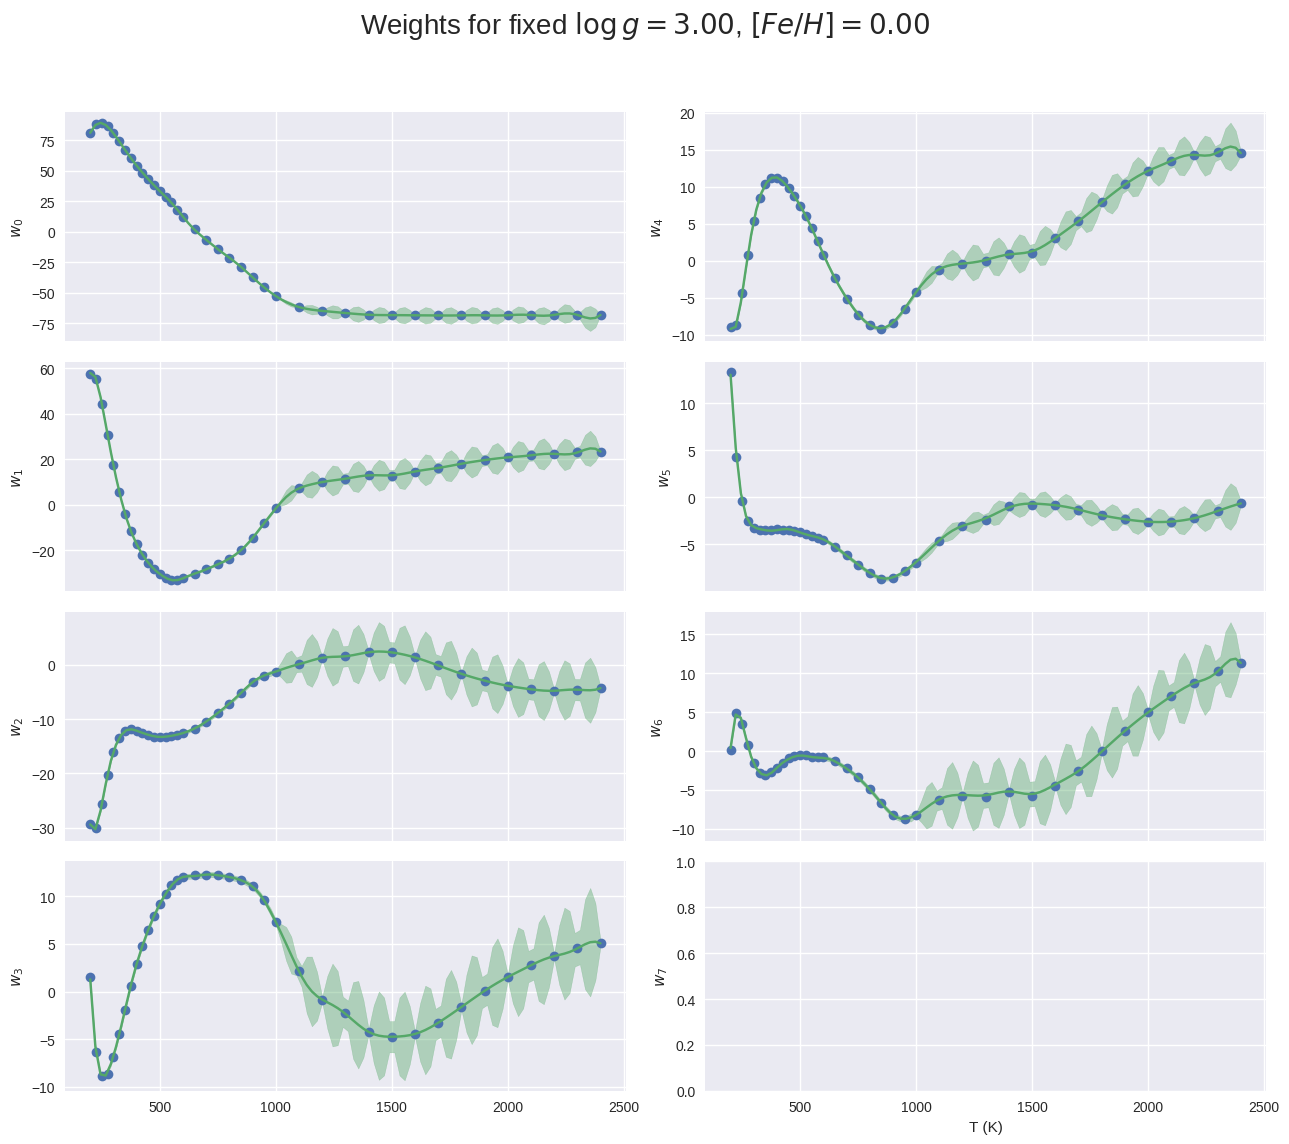

In [9]:
%matplotlib inline
from Starfish.emulator.plotting import plot_emulator

plot_emulator(emu)

If we are satisfied, let's save this emulator and move on to fitting some data.

In [10]:
emu.save("JWST_emu_MIRI_MRS_1A.hdf5")

INFO:Emulator:Saved file at JWST_emu_MIRI_MRS_1A.hdf5
